In [1]:
import numpy as np
import struct
import sys
import os
from vec_io import get_zeroled_names, read_vec
from vis_io import get_vtr, write_vtr, get_mesh, get_vtu, write_vtu
import vtk
from tqdm import tqdm, trange
from vtkmodules.util import numpy_support
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
# DEMO: reanme e.g. 1.vec to 01.vec with get_zeroled_names
names, newnames = get_zeroled_names('data', '.vec', 1)
for name, newname in zip(names, newnames):
  os.rename(name, newname)

In [2]:
vec_dir = 'data'
vec_paths = sorted([os.path.join(vec_dir, vec_file) for vec_file in os.listdir(vec_dir)])
vec0 = read_vec(vec_paths[0])

In [10]:
# generate seeds in every on each grid point of (48,48,48)
dim_coord = np.linspace(0, 1, 8, dtype=np.float32)
mesh = get_mesh(dim_coord,dim_coord,dim_coord)
mesh = mesh.reshape(-1, 3)
seeds = vtk.vtkPoints()
seeds.SetData(numpy_support.numpy_to_vtk(mesh))
seeds_dataset = vtk.vtkPointSet()
seeds_dataset.SetPoints(seeds)

seeds_source = vtk.vtkPointSource()
seeds_source.SetCenter(0.5, 0.5, 0.5)
seeds_source.SetRadius(0.1)
seeds_source.SetNumberOfPoints(10)
seeds_source.SetInputData(seeds_dataset)

# get vector field in vtk format
vec_vtr = get_vtr(vec0.shape[:-1], dim_coord, dim_coord, dim_coord, vector_fields={'velocity': vec0.reshape(-1, 3)})

# specify the vector field for vtkStreamStracer
aa = vtk.vtkAssignAttribute()
ds = vtk.vtkDataSetAttributes()
aa.SetInputData(vec_vtr)
# 1=vtkDataSetAttribute::VECTOR
# 0=vtkAssignAttribute::POINT_DATA
aa.Assign('velocity', ds.VECTORS, aa.POINT_DATA)
aa.Update()

meshe generated: (8, 8, 8, 3)


In [16]:
# get stream tracer
init_steplen = 0.2
tem_speed =1e-12
max_error = 1e-06
min_intsteplen = 0.001
max_intsteplen = 0.05
max_steps = 1000
max_length = 1

st = vtk.vtkStreamTracer()

# st.SetStartPosition(0.0, 0.0, 0.0)
st.SetInputData(vec_vtr)
# st.SetInputConnection(aa.GetOutputPort())
# st.SetStartPosition(0.5,0.5,0.5)
st.SetSourceConnection(seeds_source.GetOutputPort())
# st.SetSourceData(seeds_dataset)

integrator = vtk.vtkRungeKutta45()
st.SetIntegratorTypeToRungeKutta45()
st.SetIntegrationDirectionToForward()
st.SetInitialIntegrationStep(init_steplen)
st.SetMinimumIntegrationStep(min_intsteplen)
st.SetMaximumIntegrationStep(max_intsteplen)
st.SetMaximumNumberOfSteps(max_steps)
st.SetMaximumPropagation(max_length)
st.SetTerminalSpeed(tem_speed)
st.SetIntegrationStepUnit(st.CELL_LENGTH_UNIT)


# st.SetSourceData(seeds_dataset)

st.Update()

pdm = st.GetOutput()
pdm.GetNumberOfCells()

20

In [17]:
sls = [0]*pdm.GetNumberOfCells()
ids = [0]*pdm.GetNumberOfCells()
sl_lens = np.zeros(pdm.GetNumberOfCells())
for i in trange(pdm.GetNumberOfCells()):
  sl = pdm.GetCell(i)
  points = sl.GetPoints()
  points_np = numpy_support.vtk_to_numpy(points.GetData())
  id_np = i*np.ones((len(points_np), 1))
  sl_lens[i] = len(points_np)
  ids[i] = id_np
  sls[i] = points_np
  # print(points_np.shape)
sl_points_pos = np.concatenate(sls)
sl_points_id = np.concatenate(ids)
display(sl_points_pos.max(), sl_lens.mean())

100%|██████████| 20/20 [00:00<00:00, 19160.82it/s]


0.9956808090209961

40.95

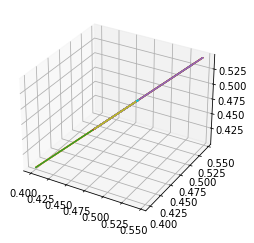

In [18]:
# Data for a three-dimensional line
fig = plt.figure()
ax = plt.axes(projection='3d')
for sl in sls:
  ax.plot3D(sl[:,0], sl[:,0], sl[:,0])
plt.show()

In [ ]:
sl_vtu = get_vtu(sl_points_pos, scalar_fields={'id': sl_points_id})
write_vtu('mysl.vtu', sl_vtu)